# Export dataset

Import .nc


Post process: - no sit < 0
              - spatial smoothing ?
        
Inform metadata


Save daily file as .nc

In [30]:
from src.data_preparation import merge_TOPAZ

In [31]:
sit_ml, chrono_ml = merge_TOPAZ.load_nc()
sic_fr, chrono_fr = merge_TOPAZ.load_sic_fr()

Loading ML-SIT...
	1992-1998
	1999-2010
	2011-2022
Merging...
Loading SIC freerun...
	1991-1998
	1999-2010
	2011-2022
Merging...


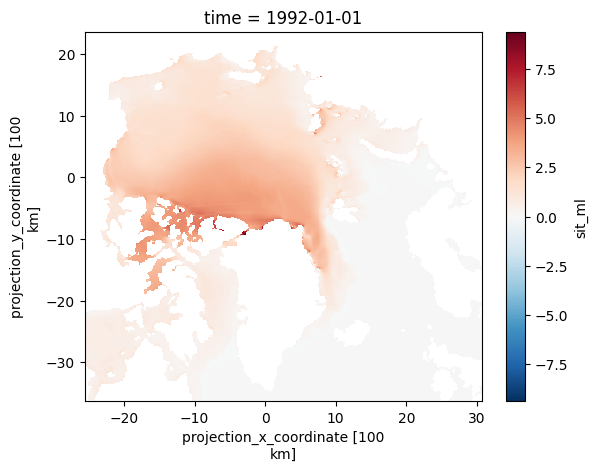

In [32]:
sit_ml.isel(time=0).plot()

## Post Process

In [33]:
# Negative sea ice thickness is set to 0m

sit_pp = sit_ml.where((sit_ml>0) | (sit_ml.isnull()), 0)

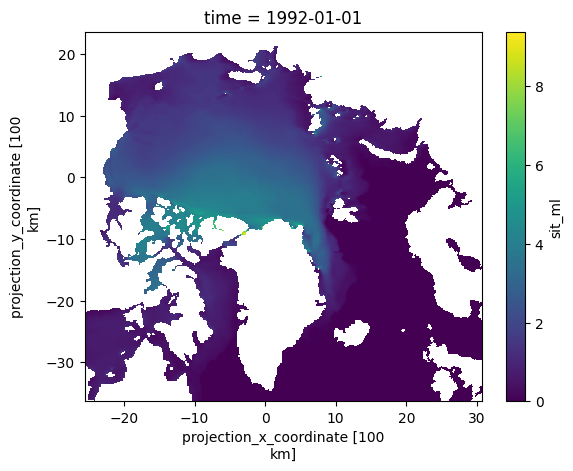

In [34]:
sit_pp.isel(time=0).plot()

## Save

In [35]:
import pandas as pd
import xarray as xr
from datetime import date
import datetime

# LOOP ON DAY

In [36]:
sit_pp.attrs

{}

In [37]:
sit_pp.attrs['units'] = 'm'
sit_pp.attrs['standard_name'] = 'sea_ice_thickness'
sit_pp.attrs['grid_mapping_name'] = 'polar_stereographic'


In [43]:
sic_fr.attrs['grid_mapping_name'] = 'polar_stereographic'
del sic_fr.attrs['grid_mapping']

In [44]:
sic_fr

<xarray.DataArray 'siconc' (time: 11292, y: 479, x: 450)>
dask.array<concatenate, shape=(11292, 479, 450), dtype=float32, chunksize=(4413, 479, 450), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1992-01-01 1992-01-02 ... 2022-11-30
    latitude   (y, x) float32 51.68 51.74 51.8 51.85 ... 56.57 56.49 56.41 56.33
    longitude  (y, x) float32 -80.12 -79.99 -79.86 -79.73 ... 82.73 82.61 82.5
  * x          (x) float32 -25.5 -25.38 -25.25 -25.12 ... 30.25 30.38 30.5 30.62
  * y          (y) float32 -36.25 -36.12 -36.0 -35.88 ... 23.12 23.25 23.38 23.5
Attributes:
    cell_methods:       area: mean
    standard_name:      sea_ice_area_fraction
    units:              1
    grid_mapping_name:  polar_stereographic

In [67]:
metadata = dict(
    title='Sea Ice Thickness (SIT)',
    description='Daily Sea Ice Thickness reconstructed by combining machine learning and data assimilation',
    project='TARDIS',
    comment='Dataset for Edel et al. (2024), Reconstruction of Arctic sea ice thickness (1992-2010) based on a '
    'hybrid machine learning and data assimilation approach, The Cryosphere, submitted.',
    summary='Using variables from TOPAZ4, CS2SMOS, ERA5, sea ice age. References can be found in Edel et al. (2024)',
    institution='Nansen Environmental and Remote Sensing Center, Jahnebakken 3, N-5007 Bergen, Norway',
    publisher_name='NERSC',
    publisher_email='post@nersc.no',
    publisher_url='https://nersc.no/',
    creator='Leo Edel',
    contact_email_primary='leo.edel@nersc.no',
    contact_email_secondary='laurent.bertino@nersc.no',
    product_version='0.0.1-submitted',
    Conventions='CF-1.4',
    license='CC BY 4.0',
    production_date=f'{date.today()}',
    time_coverage_start='1992-01-01',
    time_coverage_end='2022-11-31',
    projection_grid_name='polar_stereographic',
    projection_proj4='+proj=stere +lon_0=-45 +lat_0=90 +k=1 +R=6378273 +no_defs',
    projection_latitude_of_projection_origin='90.',
    projection_longitude_of_projection_origin='-45.',
    projection_scale_factor_at_projection_origin='1.',
    projection_straight_vertical_longitude_from_pole='-45.',
    projection_earth_radius='6378273.',
    projection_false_easting='0.',
    projection_false_northing='0.',
   )

In [68]:
# first_pred = pd.to_datetime(self.Xc['time'][0].data).strftime('%Y-%m-%d')
# last_pred = pd.to_datetime(self.Xc['time'][-1].data).strftime('%Y-%m-%d')

odata = xr.Dataset(data_vars={'sit':sit_pp,
                              'sic':sic_fr},
                   attrs=metadata
                  )

In [10]:
# -----------------------------------------------------

sday = datetime.datetime(1992, 1, 1).strftime('%Y%m%d')

odir = f'/scratch/project_465000269/edelleo1/Leo/export_SIT_TOPAZ4-ML/' 
oname = f'SIT_TOPAZ4-ML_{sday}.nc'

# odata.to_netcdf(f'{odir}{oname}')


# print(self.sit)
print(f'Saved as: {odir}{oname}')

Saved as: /scratch/project_465000269/edelleo1/Leo/export_SIT_TOPAZ4-ML/SIT_TOPAZ4-ML_19920101.nc


In [14]:
import numpy as np

In [69]:
save_daily_nc(odata)

Saved as: /scratch/project_465000269/edelleo1/Leo/export_SIT_TOPAZ4-ML/1992/SIT_TOPAZ4-ML_19920101.nc
Saved as: /scratch/project_465000269/edelleo1/Leo/export_SIT_TOPAZ4-ML/1992/SIT_TOPAZ4-ML_19920102.nc
Saved as: /scratch/project_465000269/edelleo1/Leo/export_SIT_TOPAZ4-ML/1992/SIT_TOPAZ4-ML_19920103.nc


In [15]:
def save_daily_nc(idata, year=1992):
    '''
    '''
    
    odir = f'/scratch/project_465000269/edelleo1/Leo/export_SIT_TOPAZ4-ML/{year}/' 
    
    d1 = datetime.date(year,1,1)
#     d2 = datetime.date(year,12,31)
    d2 = datetime.date(year,1,3)
    
    
    all_days = np.array([d1 + datetime.timedelta(days=x) for x in range((d2-d1).days + 1)])
    
    for day in all_days:
        
        # identify index to plot
        chrono = pd.DataFrame({'date':pd.to_datetime(idata.sit.time.to_numpy())})
        chrono_dt = np.array([dt.date() for dt in chrono.date])
        t_idx = np.where(chrono_dt==day)[0][0]
        
        sday = day.strftime('%Y%m%d')
        
        oname = f'SIT_TOPAZ4-ML_{sday}.nc'
        idata.isel(time=t_idx).to_netcdf(f'{odir}{oname}')
        print(f'Saved as: {odir}{oname}')    

In [11]:
odata

<xarray.Dataset>
Dimensions:    (time: 11292, x: 450, y: 479)
Coordinates:
  * time       (time) datetime64[ns] 1992-01-01 1992-01-02 ... 2022-11-30
  * x          (x) float32 -25.5 -25.38 -25.25 -25.12 ... 30.25 30.38 30.5 30.62
  * y          (y) float32 -36.25 -36.12 -36.0 -35.88 ... 23.12 23.25 23.38 23.5
    latitude   (y, x) float32 51.68 51.74 51.8 51.85 ... 56.57 56.49 56.41 56.33
    longitude  (y, x) float32 -80.12 -79.99 -79.86 -79.73 ... 82.73 82.61 82.5
Data variables:
    sit        (time, y, x) float64 dask.array<chunksize=(2557, 479, 450), meta=np.ndarray>
    sic        (time, y, x) float32 dask.array<chunksize=(2557, 479, 450), meta=np.ndarray>
Attributes: (12/23)
    title:                                             Sea Ice Thickness (SIT)
    description:                                       Daily Sea Ice Thicknes...
    project:                                           TARDIS
    comment:                                           Dataset for Edel et al...
    institution:                                       Nansen Environmental a...
    publisher_name:                                    NERSC (Leo Edel)
    ...                                                ...
    projection_longitude_of_projection_origin:         -45.
    projection_scale_factor_at_projection_origin:      1.
    projection_straight_vertical_longitude_from_pole:  -45.
    projection_earth_radius:                           6378273.
    projection_false_easting:                          0.
    projection_false_northing:                         0.

# ___________________________________________________________________

## Easy load

In [14]:
import os
import xarray as xr
from glob import glob

In [8]:
idir = '/scratch/project_465000269/edelleo1/Leo/export_SIT_TOPAZ4-ML/*/'

# get all files
list_files = sorted(glob(os.path.join(idir,'*.nc')))

# Open files
nc = xr.open_mfdataset(list_files, combine='nested', concat_dim='time')

# Read sea ice thickness
sit = nc['sit']

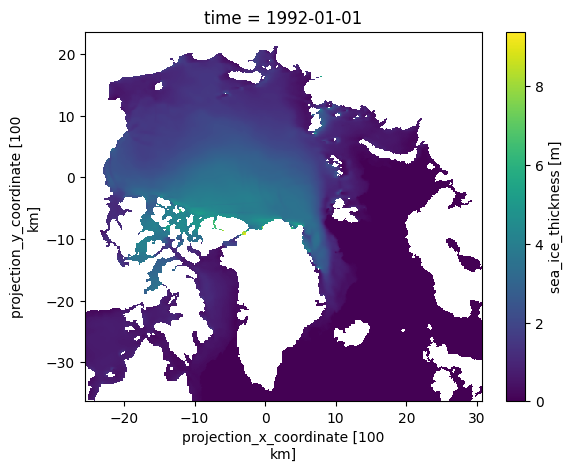

In [18]:
# Quick plot
sit.isel(time=0).plot()